## Generation of novel molecules using WGAN-GP with R-GCN
## Dataset 'qm9.csv' from  http://quantum-machine.org/datasets/

### **1. Import packages and libraries**

In [ ]:
!pip -q install rdkit-pypi
!pip -q install Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 9.8 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd

from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

import tensorflow as tf
from tensorflow import keras

RDLogger.DisableLog("rdApp.*")

### **2. Read data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/GAN Molecules')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('qm9.csv')
print(df.shape)
df.head()

(133885, 21)


,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,gdb_1,C,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,...,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772
1,gdb_2,N,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,...,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802
2,gdb_3,O,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,...,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171
3,gdb_4,C#C,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,...,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,-385.501997,-387.237686,-389.016047,-365.800724
4,gdb_5,C#N,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,...,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278,-301.820534,-302.906752,-304.091489,-288.720028


### **3. Create Smiles List**

In [ ]:
smiles_list = df.smiles.unique().tolist()
print('Total Smiles:', len(smiles_list))
print('First five items:', smiles_list[:5])
print('Maximum atom count:', max([len(x) for x in smiles_list if x.isalpha()]))

Total Smiles: 133802
First five items: ['C', 'N', 'O', 'C#C', 'C#N']
Maximum atom count: 9


In [ ]:
# Get unique atoms
smiles_char = set(''.join(smiles_list))
print('Smiles characters:', smiles_char)

unique_atoms = set(char.upper() for char in smiles_char if char.isalpha())
print('Unique atoms:', unique_atoms)

Smiles characters: {'n', 'C', '2', '5', ')', '=', '[', '3', '4', '-', '+', 'O', '1', 'c', 'o', 'F', ']', 'H', '#', '(', 'N'}
Unique atoms: {'C', 'H', 'O', 'F', 'N'}


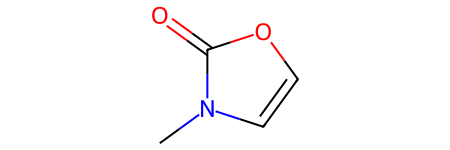

In [ ]:
smiles = smiles_list[1000]
mol = Chem.MolFromSmiles(smiles)
mol

### **4. Define helper functions**

In [ ]:
# Atom Mapping
atom_mapping = {'C':0, 'N':1, 'O':2, 'F':4, 0:'C', 1:'N', 2:'O', 3:'F'}

# Bond Mapping
bond_mapping = {'SINGLE':0, 'DOUBLE':1, 'TRIPLE':2, 'AROMATIC':3, 0:Chem.BondType.SINGLE, 1:Chem.BondType.DOUBLE, 2:Chem.BondType.TRIPLE, 3:Chem.BondType.AROMATIC}

# Set Parameters
ATOM_DIM = 4+1
BOND_DIM = 4+1
MAX_ATOMS = 9
LATENT_DIM = 64

### **5. Convert smiles to graph**

In [ ]:
def smiles_to_graph(smiles):

  # smiles to molecule
  mol = Chem.MolFromSmiles(smiles)

  # Initialize adjacency and features matrices
  adjacency = np.zeros((BOND_DIM, MAX_ATOMS, MAX_ATOMS), dtype=np.float32)
  features = np.zeros((MAX_ATOMS, ATOM_DIM), dtype=np.float32)

  # Build features matrix
  for atom in mol.GetAtoms():
    i = atom.GetIdx()
    features[i, atom_mapping[atom.GetSymbol()]] = 1
    # Build adjacency matrix
    for neighbor in atom.GetNeighbors():
      j = neighbor.GetIdx()
      bond = mol.GetBondBetweenAtoms(i,j)
      bond_type = bond.GetBondType().name
      adjacency[bond_mapping[bond_type], [i,j], [j,i]] = 1

  # Assign all 'non-atoms' = 1
  features[np.sum(features, axis=1)==0, -1] = 1
  # Assign all 'non-bonds' or 'absence of bonds' = 1
  adjacency[-1, np.sum(adjacency[:-1], axis=0)==0] = 1

  return adjacency, features


### **6. Convert graph to molecule**

In [ ]:
def graph_to_molecule(graph):

  # Unpack the graph
  adjacency, features = graph

  # Create an rdkit molecule object for editing
  molecule = Chem.RWMol()

  # keep indices associated with atoms and bond connectivities
  keep_index = np.where((np.argmax(features, axis=1) != ATOM_DIM-1) & (np.sum(adjacency[:-1], axis=(0,1)) != 0))[0]
  features = features[keep_index]
  adjacency = adjacency[:,keep_index,:][:,:,keep_index]

  # Add atoms
  for i in np.argmax(features, axis=1):
    atom = Chem.Atom(atom_mapping[i])
    molecule.AddAtom(atom)

  # Add bonds
  (bond_ij, i, j) =  np.where(np.triu(adjacency==1))
  for (bond_ij, i, j) in zip(bond_ij, i, j):
    if i==j or bond_ij==BOND_DIM-1:
      continue
    bond_type = bond_mapping[bond_ij]
    molecule.AddBond(int(i), int(j), bond_type)

  # Sanitize molecule
  flag = Chem.SanitizeMol(molecule, catchErrors=True)
  if flag != Chem.SanitizeFlags.SANITIZE_NONE:
    return None

  return molecule

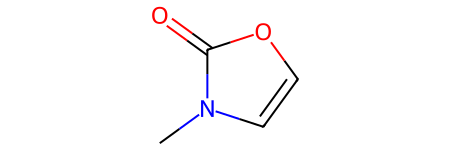

In [ ]:
graph_to_molecule(smiles_to_graph(smiles))

### **7. Generate Training data**

In [ ]:
adjacency_tensor, features_tensor = [],[]

for smiles in smiles_list[::10]:
  adjacency, features = smiles_to_graph(smiles)
  adjacency_tensor.append(adjacency)
  features_tensor.append(features)

# Convert list to numpy array
adjacency_tensor = np.array(adjacency_tensor)
features_tensor = np.array(features_tensor)

print(adjacency_tensor.shape, features_tensor.shape)

(13381, 5, 9, 9) (13381, 9, 5)


### **8. Create Generator Function**

In [ ]:
def GraphGenerator(latent_dim, dense_units, dropout_rate, adjacency_shape, features_shape):

  # Input layer
  z = keras.layers.Input(shape=(latent_dim))
  x = z

  # Dense layers
  for units in dense_units:
    x = keras.layers.Dense(units, activation = 'tanh')(x)
    x = keras.layers.Dropout(dropout_rate)(x)

  # adjacency output
  x_adjacency = keras.layers.Dense(tf.math.reduce_prod(adjacency_shape))(x)
  x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)
  x_adjacency = 0.5 * (x_adjacency + tf.transpose(x_adjacency, perm=(0,1,3,2)))
  x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)

  # features output
  x_features = keras.layers.Dense(tf.math.reduce_prod(features_shape))(x)
  x_features = keras.layers.Reshape(features_shape)(x_features)
  x_features = keras.layers.Softmax(axis=2)(x_features)

  return keras.Model(inputs=z, outputs=[x_adjacency, x_features], name='Generator')

In [ ]:
generator = GraphGenerator(latent_dim=LATENT_DIM,
                           dense_units = [128,256,512],
                           dropout_rate = 0.2,
                           adjacency_shape=(BOND_DIM, MAX_ATOMS, MAX_ATOMS),
                           features_shape=(MAX_ATOMS, ATOM_DIM))
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  8320      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128)                  0         ['dense[0][0]']               
                                                                                                  
 dense_1 (Dense)             (None, 256)                  33024     ['dropout[0][0]']             
                                                                                          

### **9. Create Discriminator Function**

### **Create custom R-GCN layer**

In [ ]:
class RelationalGraphConvLayer(keras.layers.Layer):

  # Initialize layer
  def __init__(self, rgcn_units, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=None, use_bias=False, bias_initializer='zeros', bias_regularizer=None, **kwargs):
    super().__init__(**kwargs)
    self.rgcn_units = rgcn_units
    self.activation = keras.activations.get(activation)
    self.kernel_initializer = keras.initializers.get(kernel_initializer)
    self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
    self.use_bias = use_bias
    self.bias_initializer = keras.initializers.get(bias_initializer)
    self.bias_regularizer = keras.regularizers.get(bias_regularizer)

 # Build layer
  def build(self, input_shape):

    # Set kernel weights and bias
    bond_dim = input_shape[0][1]
    atom_features = input_shape[1][2]
    self.kernel = self.add_weight(shape=(bond_dim, atom_features, self.rgcn_units),
                                   initializer = self.kernel_initializer,
                                   regularizer = self.kernel_regularizer,
                                   trainable = True,
                                   name = 'W',
                                   dtype = np.float32)

    if self.use_bias:
      self.bias = self.add_weight(shape=(bond_dim, 1, self.rgcn_units),
                                   initializer = self.bias_initializer,
                                   regularizer = self.bias_regularizer,
                                   trainable = True,
                                   name = 'b',
                                   dtype = np.float32)

  # Run R-GCN layer
  def call(self, inputs):

    # Unpack inputs
    adjacency, features = inputs
    # Neighborhood aggregation
    x = tf.matmul(adjacency, features[:,None,:,:])
    # Linear transformation
    x = tf.matmul(x, self.kernel)
    if self.use_bias:
      x+=self.bias
    # Average aggregation
    x_reduced = tf.reduce_sum(x, axis=1)
    return self.activation(x_reduced)


### **Discriminator Function with R-GCN and Dense Layers**

In [ ]:
def GraphDiscriminator(adjacency_shape, features_shape, rgcn_units, dense_units, dropout_rate):

  # R-GCN Input layer
  x_adjacency = keras.layers.Input(shape=adjacency_shape)
  x_features = keras.layers.Input(shape=features_shape)

  # Run R-GCN to update atom features
  features_transformed = x_features
  for units in rgcn_units:
    features_transformed = RelationalGraphConvLayer(units)([x_adjacency, features_transformed])

  # Downsampling of transformed features
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)

  # Pass through Dense layers
  for units in dense_units:
    x = keras.layers.Dense(units, activation = 'relu')(x)
    x = keras.layers.Dropout(dropout_rate)(x)

  # Final output
  x_out = keras.layers.Dense(1, activation='sigmoid', dtype=np.float32)(x)

  return keras.Model(inputs=[x_adjacency, x_features], outputs=x_out)


In [ ]:
discriminator = GraphDiscriminator(adjacency_shape=(BOND_DIM, MAX_ATOMS, MAX_ATOMS),
                                   features_shape = (MAX_ATOMS, ATOM_DIM),
                                   rgcn_units = [128,128,128,128],
                                   dense_units = [512,512],
                                   dropout_rate = 0.2)
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 5, 9, 9)]            0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 9, 5)]               0         []                            
                                                                                                  
 relational_graph_conv_laye  (None, 9, 128)               3200      ['input_4[0][0]',             
 r_4 (RelationalGraphConvLa                                          'input_5[0][0]']             
 yer)                                                                                             
                                                                                            

### **10. Generator + Discriminator -> WGAN with Gradient Penalty**

In [ ]:
class GraphWGAN(keras.Model):
  # Initialize model
  def __init__(self, generator, discriminator, generator_steps=1, discriminator_steps=1, gp_weight=10, **kwargs):
    super().__init__(**kwargs)
    self.generator = generator
    self.discriminator = discriminator
    self.generator_steps = generator_steps
    self.discriminator_steps = discriminator_steps
    self.gp_weight = gp_weight
    self.latent_dim = self.generator.input_shape[-1]

  # Compile model
  def compile(self, optimizer_generator, optimizer_discriminator, **kwargs):
    super().compile(**kwargs)
    self.optimizer_generator = optimizer_generator
    self.optimizer_discriminator = optimizer_discriminator
    self.metric_generator = keras.metrics.Mean(name='loss_gen')
    self.metric_discriminator = keras.metrics.Mean(name='loss_disc')

  # Train model
  def train_step(self, inputs):
    if isinstance(inputs[0], tuple):
      inputs = inputs[0]
      graph_real = inputs
      self.batch_size = tf.shape(inputs[0])[0]

    # Train discriminator
    for _ in range(self.discriminator_steps):

      z = tf.random.normal((self.batch_size, self.latent_dim))

      with tf.GradientTape() as tape:
        graph_generated = self.generator(z, training=True)
        logits_generated = self.discriminator(graph_generated, training=True)
        logits_real = self.discriminator(graph_real, training=True)
        loss = tf.reduce_mean(logits_generated) - tf.reduce_mean(logits_real)
        loss_gp = self.gradient_penalty(graph_generated, graph_real)
        loss = loss + self.gp_weight * loss_gp

      gradients = tape.gradient(loss, self.discriminator.trainable_weights)
      self.optimizer_discriminator.apply_gradients(zip(gradients,self.discriminator.trainable_weights))
      self.metric_discriminator.update_state(loss)

   # Train generator
    for _ in range(self.generator_steps):

      z = tf.random.normal((self.batch_size, self.latent_dim))

      with tf.GradientTape() as tape:
        graph_generated = self.generator(z, training=True)
        logits_generated = self.discriminator(graph_generated, training=True)
        loss = -tf.reduce_mean(logits_generated)

      gradients = tape.gradient(loss, self.generator.trainable_weights)
      self.optimizer_generator.apply_gradients(zip(gradients, self.generator.trainable_weights))
      self.metric_generator.update_state(loss)

    return {m.name : m.result() for m in self.metrics}

  # Gradient Penalty
  def gradient_penalty(self, graph_real, graph_generated):

    # Unpack graphs
    adjacency_real, features_real = graph_real
    adjacency_generated, features_generated = graph_generated

    # Generate interpolated graphs (adjacency_interp and features_interp)
    alpha = tf.random.uniform([self.batch_size])
    alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
    adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
    alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
    features_interp = (features_real * alpha) + (1 - alpha) * features_generated

    # Compute the logits of interpolated graphs
    with tf.GradientTape() as tape:
        tape.watch(adjacency_interp)
        tape.watch(features_interp)
        logits = self.discriminator(
            [adjacency_interp, features_interp], training=True)

    # Compute the gradients with respect to the interpolated graphs
    grads = tape.gradient(logits, [adjacency_interp, features_interp])
    # Compute the gradient penalty
    grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
    grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
    return tf.reduce_mean(
        tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1))
        + tf.reduce_mean(grads_features_penalty, axis=(-1)))


### **11. Train model**

In [ ]:
wgan = GraphWGAN(generator, discriminator, discriminator_steps=1)

wgan.compile(optimizer_generator = keras.optimizers.Adam(learning_rate=5e-4),
             optimizer_discriminator = keras.optimizers.Adam(learning_rate=5e-4))

wgan.fit([adjacency_tensor,features_tensor], epochs=10, batch_size=16)


Epoch 1/10
837/837 [==============================] - 108s 119ms/step - loss_gen: 0.6646 - loss_disc: -1.4252
Epoch 2/10
837/837 [==============================] - 99s 118ms/step - loss_gen: 0.5839 - loss_disc: -1.7246
Epoch 3/10
837/837 [==============================] - 96s 114ms/step - loss_gen: 0.8574 - loss_disc: -1.7936
Epoch 4/10
837/837 [==============================] - 95s 114ms/step - loss_gen: 0.8106 - loss_disc: -1.9500
Epoch 5/10
837/837 [==============================] - 96s 114ms/step - loss_gen: 0.1213 - loss_disc: -1.8496
Epoch 6/10
837/837 [==============================] - 95s 113ms/step - loss_gen: 0.4498 - loss_disc: -1.9512
Epoch 7/10
837/837 [==============================] - 94s 113ms/step - loss_gen: 0.6978 - loss_disc: -1.9446
Epoch 8/10
837/837 [==============================] - 94s 112ms/step - loss_gen: 0.7482 - loss_disc: -1.9835
Epoch 9/10
837/837 [==============================] - 94s 112ms/step - loss_gen: 0.6657 - loss_disc: -1.8955
Epoch 10/10
837/83

### **Metrics**

In [ ]:
for m in wgan.metrics:
  print(m.name, m.result().numpy())

loss_gen 0.7903562
loss_disc -1.9402003


###**12. Generate new molecules**

In [ ]:
def sample(generator, batch_size):

  # Input noise
  z = tf.random.normal((batch_size, LATENT_DIM))
  # Predicted graph from generator
  graph = generator.predict(z)

  # Get the most probable bondtype between each atom pair from adjacency tensor
  adjacency = tf.argmax(graph[0], axis=1)
  # Get one-hot encoded representation of adjacency tensor
  adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
  # Set diagonal elemest to zero to remove self-bonding
  adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))

  # Get the most probable atom type from feature tensor
  features = tf.argmax(graph[1], axis=2)
  # Get one-hot encoded repreentation of feature tensor
  features = tf.one_hot(features, depth=ATOM_DIM, dtype=np.float32)

  return [graph_to_molecule([adjacency[i].numpy(), features[i].numpy()]) for i in range(batch_size)]

2/2 [==============================] - 0s 6ms/step


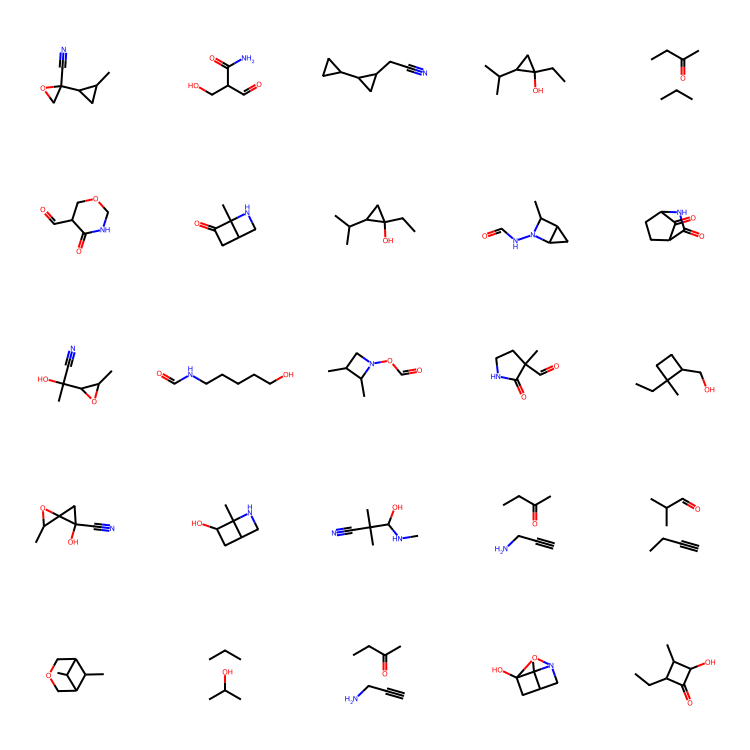

In [ ]:
molecules = sample(wgan.generator, batch_size=48)

MolsToGridImage([m for m in molecules if m is not None][:25], molsPerRow=5, subImgSize=(150,150))